In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local
from scipy import ndimage
from skimage import measure
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

## Variables utiles

In [2]:
bkg_size = 7
padding_bkg = 3

# Definición de funciones

In [3]:
def sinvecinos(matriz):
    filas,columnas = matriz.shape
    for i in range(filas-1):
        for j in range(columnas-1):
            if(matriz[i+1,j]==0 and matriz[i-1,j]==0 and matriz[i,j+1]==0 and matriz[i,j-1]==0):
                matriz[i,j] = 0
    return matriz


def micros(img, contorno):
    segm = np.zeros(img.shape)

    for i in range(len(contorno)):
        segm[int(contorno[:,0][i]), int(contorno[:,1][i])] = 1

    closedimage = ndimage.binary_fill_holes(segm).astype(int)

    return closedimage

def CNR(signal,background, mode):
    if(mode == "normal"):
        mean_signal = np.sum(signal)/np.count_nonzero(signal)
        #std_signal = signal[signal !=0].std()
        mean_bkg = np.sum(background)/np.count_nonzero(background)
        std_bkg = np.nanstd(np.where(background==0, np.nan, background)) # Cambiamo ceros por NaN y calculamos la std sin los NaN (sin los ceros)
        CNR = np.abs(mean_signal - mean_bkg)/std_bkg
        return CNR,0
    elif(mode == "jackknife"):
        signalzeros1D = np.ravel(signal)
        bkgzeros1D = np.ravel(background)
        signal1D = signalzeros1D[signalzeros1D != 0]
        bkg1D = bkgzeros1D[bkgzeros1D != 0]

        mean_signals = []
        mean_bkgs = []
        std_bkgs = []
        index = np.arange(len(signal1D))

        for i in range(len(signal1D)):
            signal1Dmod = signal1D[index !=i]
            mean_signals.append(np.mean(signal1Dmod))
            bkgs1Dmod = np.append(bkg1D, [signal1D[i]])
            mean_bkgs.append(np.mean(bkgs1Dmod))
            std_bkgs.append(np.std(bkgs1Dmod))

        CNRs = np.abs( np.array(mean_signals) - np.array(mean_bkgs) )/np.array(std_bkgs)

        return np.mean(CNRs), np.std(CNRs)

def mean_nozeros(img):
    return np.sum(img)/np.count_nonzero(img)

def line(x,a,b):
    return a*x + b
    

# Importamos los datos

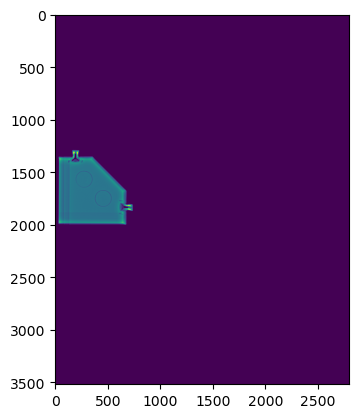

In [4]:
data = np.genfromtxt("UAP.txt")
plt.imshow(data)

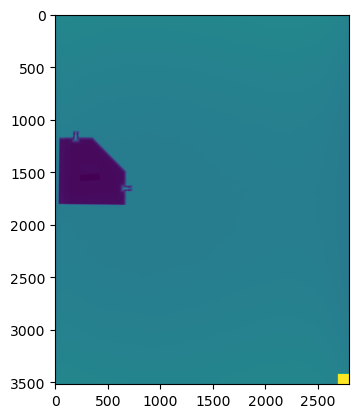

In [5]:
data2 = np.genfromtxt("UAP2.txt")
plt.imshow(data2)

# Nos concentramos en la zona donde se encuentra el fantoma

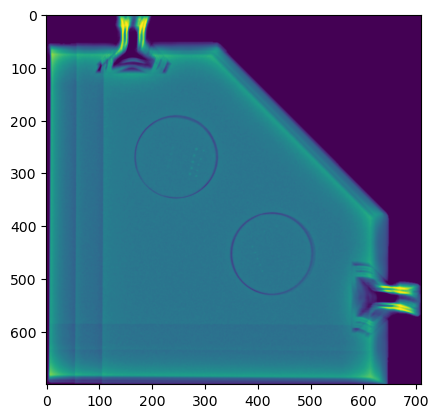

In [6]:
phantom = data[1300:2000, 30:740]
plt.imshow(phantom)

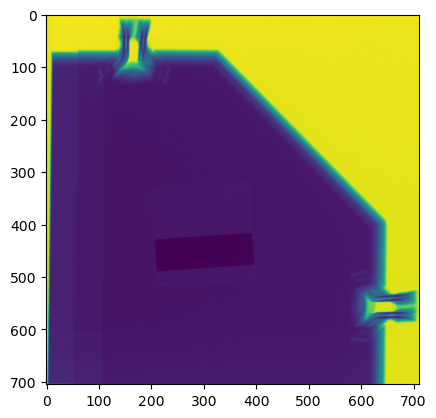

In [7]:
phantomraw = data2[1100:1805, 30:740]
plt.imshow(phantomraw)

# Definimos las zonas donde se encuentra el fantoma 1, fantoma 2 y la matriz de atenuación

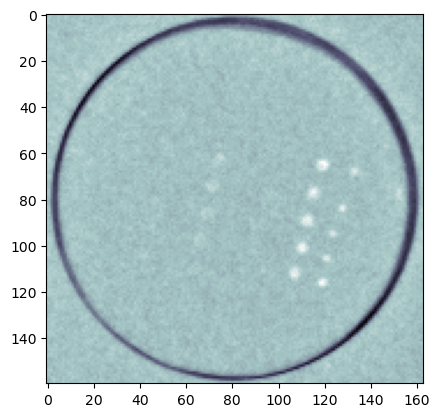

In [8]:
phantom1 = phantom[190:350, 165:328]
plt.imshow(phantom1, cmap="bone")
np.savetxt("phantom1.txt", phantom1)

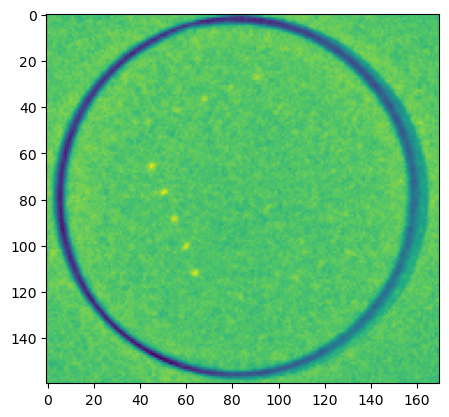

In [9]:
phantom2 = phantom[374:534, 345:515]
plt.imshow(phantom2)
np.savetxt("phantom2.txt", phantom2)

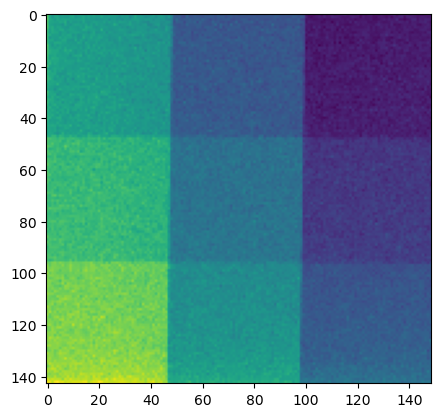

In [10]:
matrixprov = phantomraw[560:703, 7:156]
plt.imshow(matrixprov)

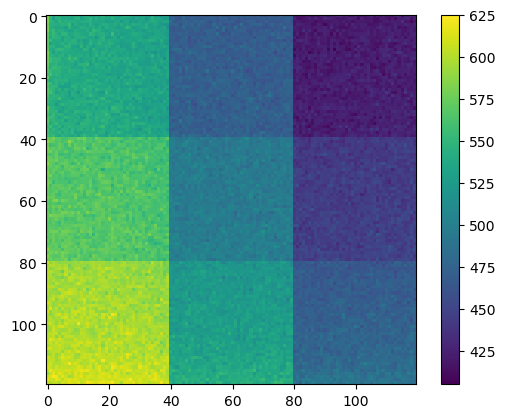

In [11]:
size = 40
#newmatrix = np.zeros(matrix.shape)
step1 = matrixprov[100:100+size, 0:0+size]
step2 = matrixprov[50:50+size, 0:0+size]
step3 = matrixprov[0:0+size, 0:0+size]
step4 = matrixprov[100:100+size, 50:50+size]
step5 = matrixprov[50:50+size, 50:50+size]
step6 = matrixprov[0:0+size, 50:50+size]
step7 = matrixprov[100:100+size, 100:100+size]
step8 = matrixprov[50:50+size, 100:100+size]
step9 = matrixprov[0:0+size, 100:100+size]

matrix = np.block([
[step3, step6, step9],
[step2, step5, step8],
[step1, step4, step7]
])

np.savetxt("matrix.txt", matrix)

plt.imshow(matrix)
plt.colorbar()
plt.savefig("attmatrix.svg")

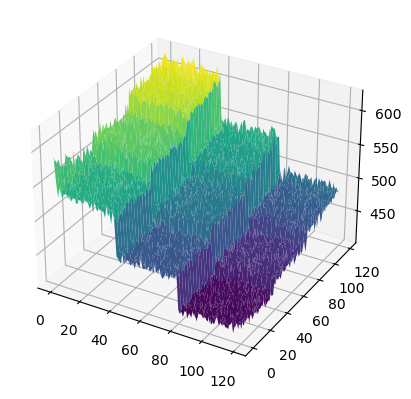

In [58]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

x = range(matrix.shape[0])
y = range(matrix.shape[1])

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, matrix, cmap="viridis")

# CNR de microcalcificaciones de fantoma 1

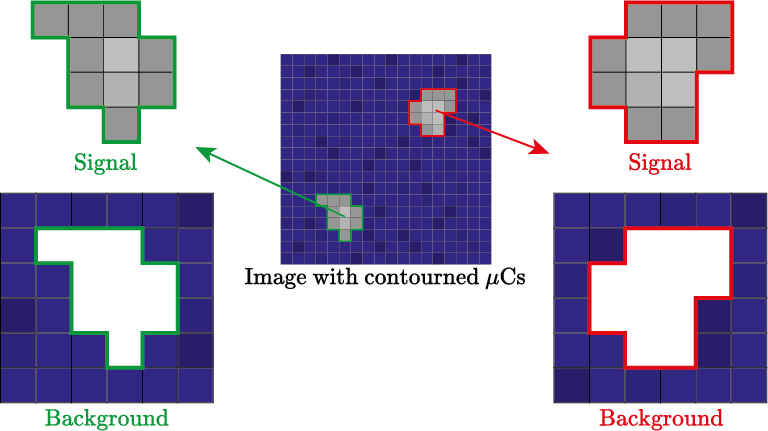

In [13]:
from IPython.display import Image
Image(filename='CNRs.png')

## Micros de HA

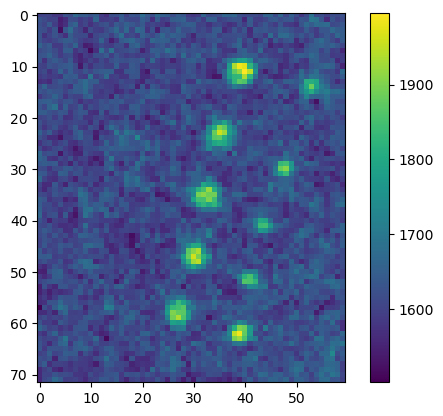

In [14]:
microsHAp1 = phantom1[54:126, 80:140]
plt.imshow(microsHAp1)
plt.colorbar()

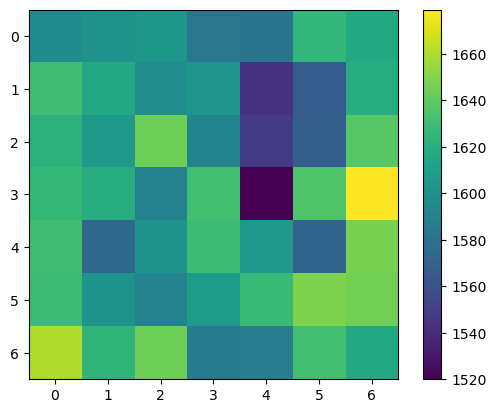

In [15]:
backgroundp1 = microsHAp1[0:0+bkg_size, 0:0+bkg_size]
plt.imshow(backgroundp1)
plt.colorbar()

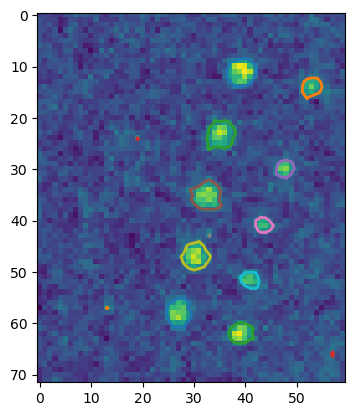

In [16]:
th = threshold_otsu(microsHAp1)
contours = measure.find_contours(microsHAp1, th)
fig, ax = plt.subplots()
ax.imshow(microsHAp1)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

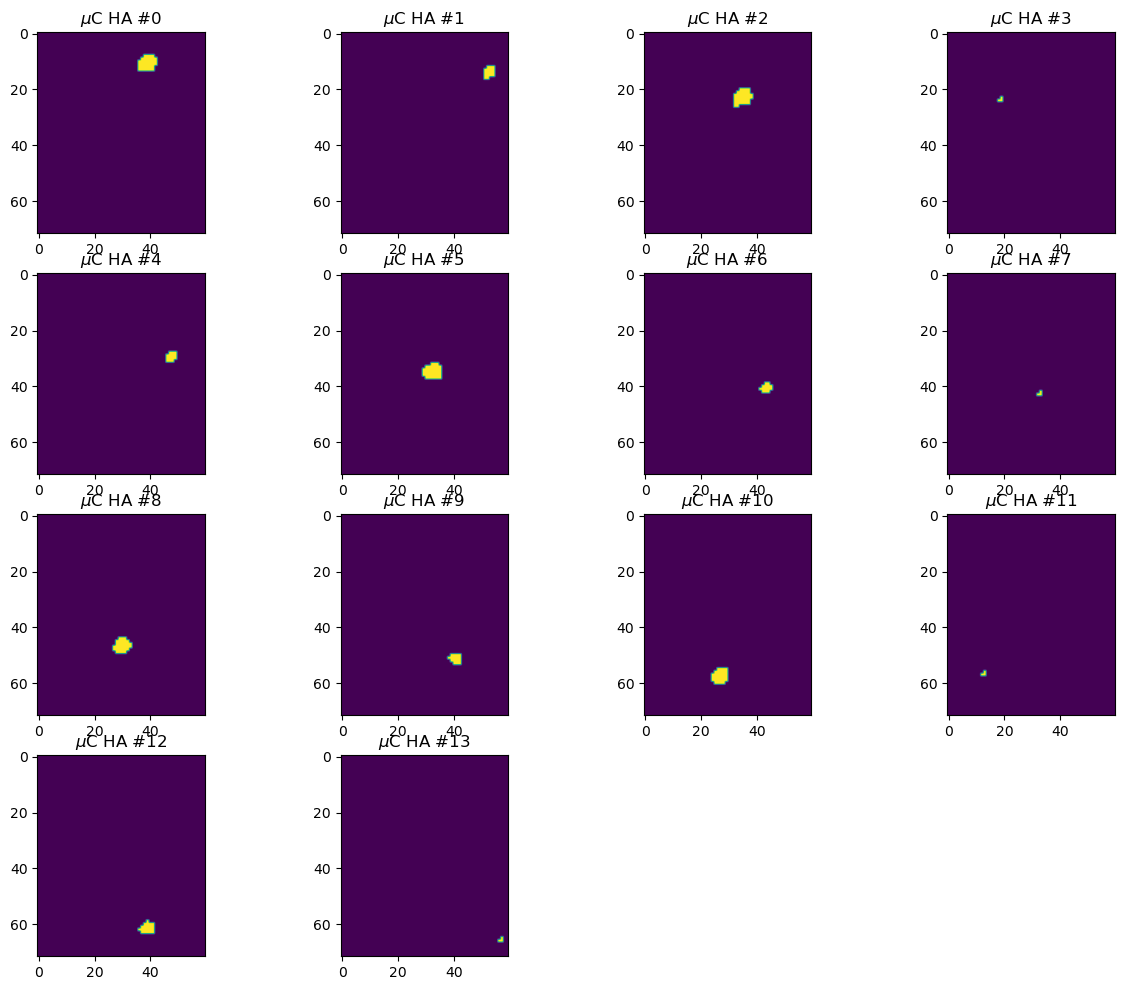

In [17]:
microsHAp1masks = []

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i, contour in enumerate(contours):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    microHAp1 = micros(microsHAp1,contour)
    microsHAp1masks.append(microHAp1)
    ax.imshow(microHAp1)
    ax.set_title(r"$\mu$C HA #{}".format(i))

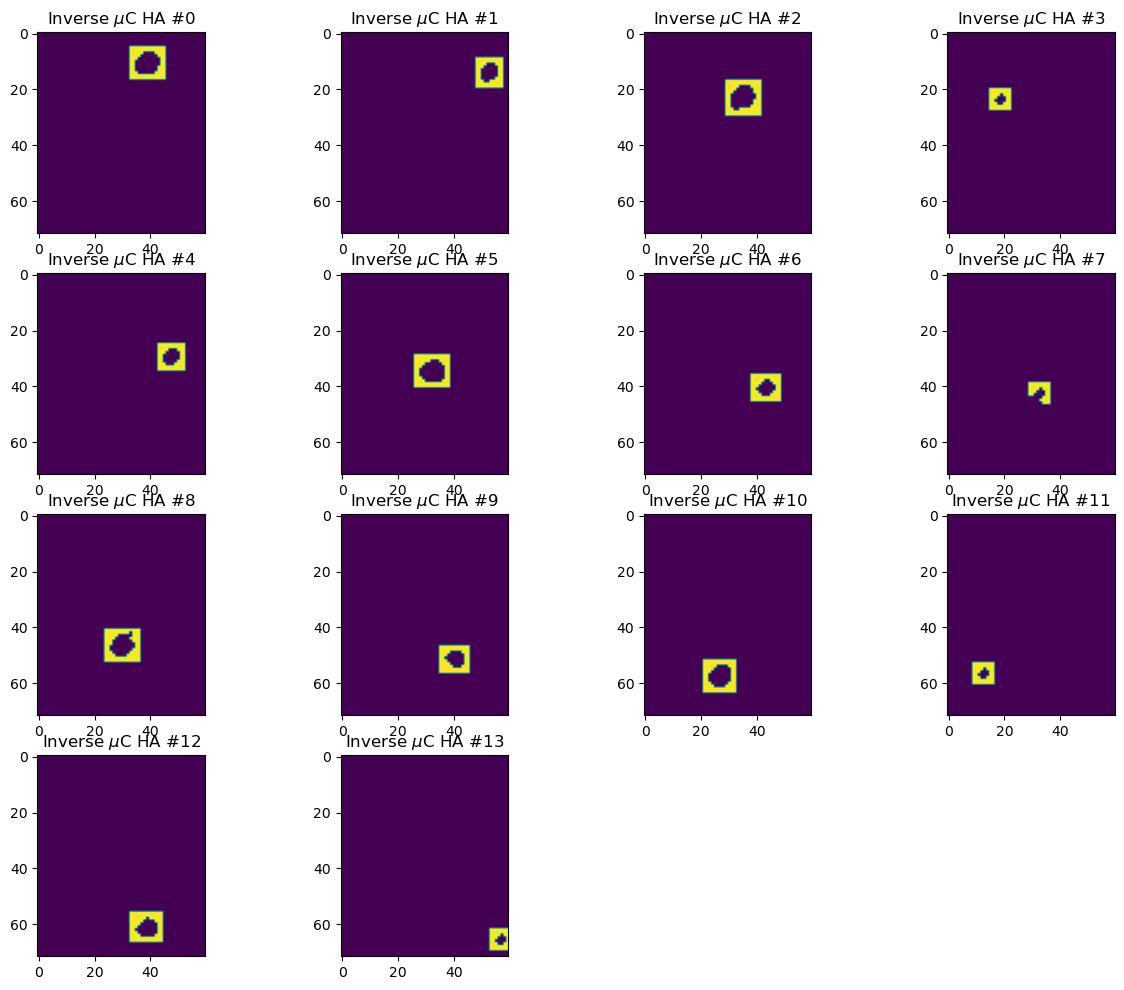

In [18]:
#ndimage.binary_fill_holes(segm).astype(int)

limits_microsHAp1 = []

for i, contour in enumerate(contours):
    mask_squaresHAp1 = np.zeros(microsHAp1.shape)
    left_border = int(np.amin(contour[:, 0]))
    right_border = int(np.amax(contour[:, 0]))
    upper_border = int(np.amin(contour[:, 1]))
    lower_border = int(np.amax(contour[:, 1]))
    mask_squaresHAp1[min(left_border,right_border)-padding_bkg:max(left_border,right_border)+padding_bkg+1, min(lower_border,upper_border)-padding_bkg:max(lower_border,upper_border)+padding_bkg+1] = 1
    limits_microsHAp1.append(mask_squaresHAp1)

masksinvHAp1 = 1 - ndimage.binary_dilation(np.array(microsHAp1masks), iterations=1)*np.array(limits_microsHAp1)

microsHAp1masksbkg = masksinvHAp1*np.array(limits_microsHAp1)


plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i, mask in enumerate(microsHAp1masksbkg):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(mask)
    ax.set_title(r"Inverse $\mu$C HA #{}".format(i))



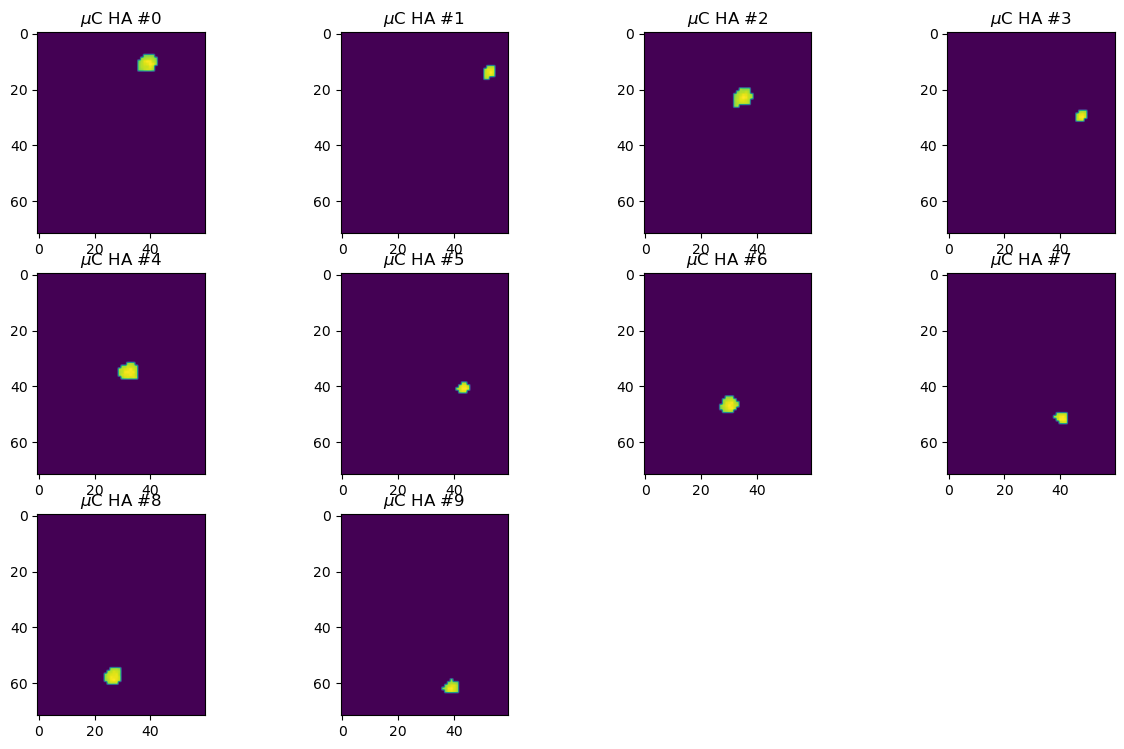

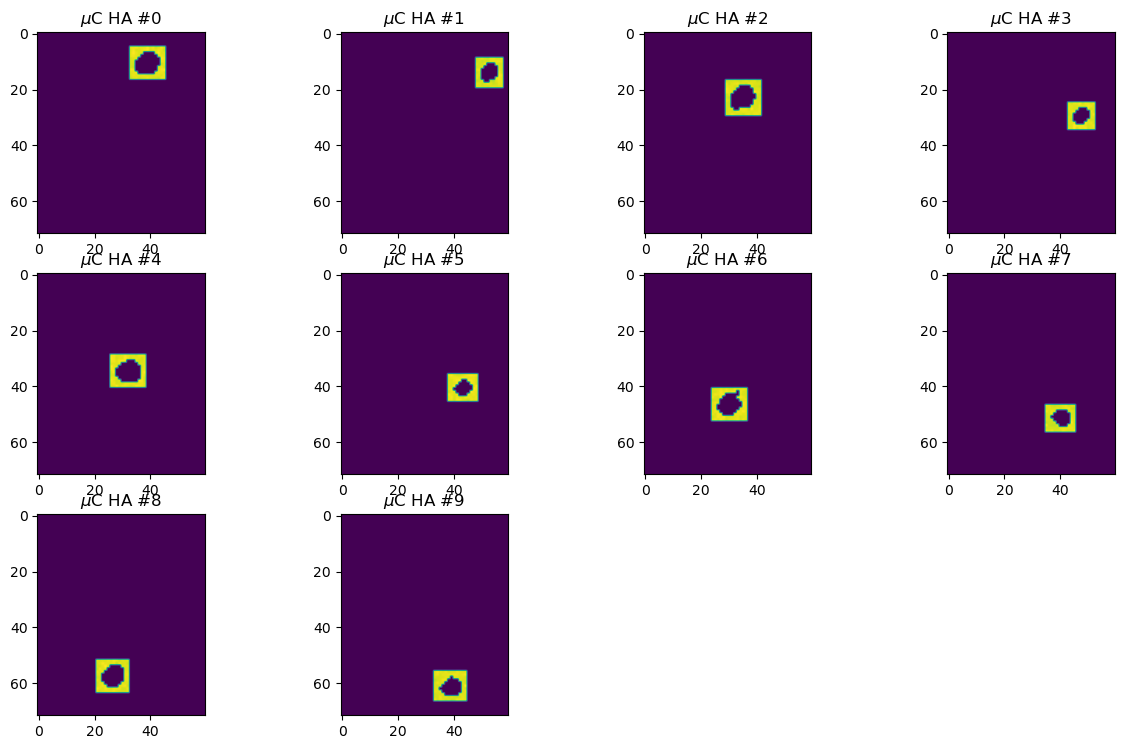

In [19]:
indicesHAp1micros = np.array([0,1,2,4,5,6,8,9,10,12]) # Indices de imagenes donde estan de verdad las micros

microsHAp1ind = [ microsHAp1*microsHAp1masks[i] for i in indicesHAp1micros ] # Creamos una lista donde cada i-esimo elemento es la imagen mltiplicada 
#por la mascara de una sola microcalcificacion

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i in range(len(indicesHAp1micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsHAp1ind[i])
    ax.set_title(r"$\mu$C HA #{}".format(i))

microsHAp1indbkg = [ microsHAp1*microsHAp1masksbkg[i] for i in indicesHAp1micros ]

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i in range(len(indicesHAp1micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsHAp1indbkg[i])
    ax.set_title(r"$\mu$C HA #{}".format(i))

<ErrorbarContainer object of 3 artists>

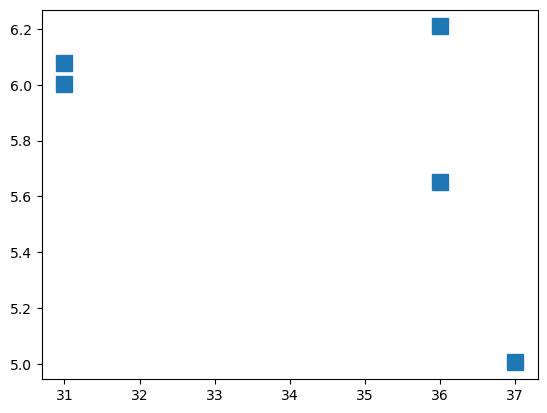

In [20]:
indicesHAp1micros600um = np.array([0,2,4,6,8])
indicesHAp1micros300um = np.array([1,3,5,7,9])


CNRs_HAp1_600um = [CNR(microsHAp1ind[index], microsHAp1indbkg[index],"normal")[0] for index in indicesHAp1micros600um]
errs_HAp1_600um = [CNR(microsHAp1ind[index], microsHAp1indbkg[index],"normal")[1] for index in indicesHAp1micros600um]
sizes_HAp1_600um = [np.count_nonzero(microsHAp1ind[index]) for index in indicesHAp1micros600um]

plt.errorbar(sizes_HAp1_600um, CNRs_HAp1_600um, yerr=errs_HAp1_600um, ls="none", marker='s', markersize=12)

<ErrorbarContainer object of 3 artists>

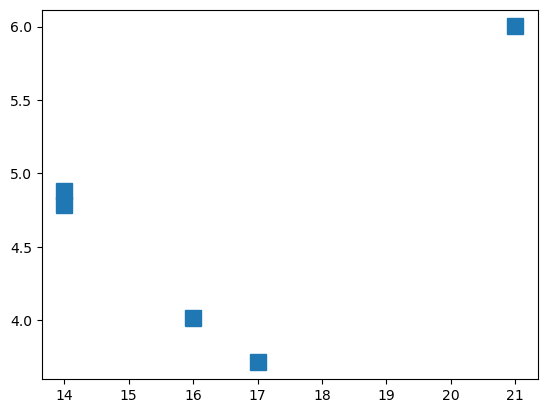

In [21]:
CNRs_HAp1_300um = [CNR(microsHAp1ind[index], microsHAp1indbkg[index],"normal")[0] for index in indicesHAp1micros300um]
errs_HAp1_300um = [CNR(microsHAp1ind[index], microsHAp1indbkg[index],"normal")[1] for index in indicesHAp1micros300um]
sizes_HAp1_300um = [np.count_nonzero(microsHAp1ind[index]) for index in indicesHAp1micros300um]

plt.errorbar(sizes_HAp1_300um, CNRs_HAp1_300um, yerr=errs_HAp1_300um, ls="none", marker='s', markersize=12)

## Micros de Al2O3

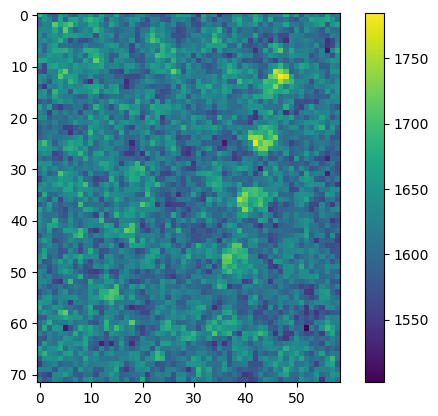

In [22]:
microsAlp1 = phantom1[50:122, 28:87]
plt.imshow(microsAlp1)
plt.colorbar()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5708\199733734.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newcontours = np.array(newcontours)


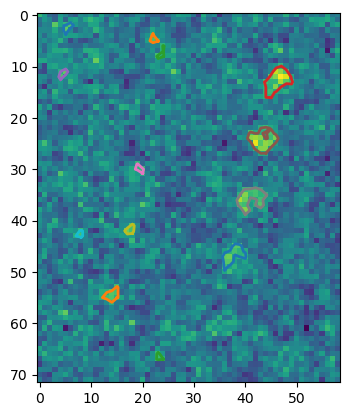

In [23]:
#th = threshold_otsu(microsAlp1)
contours = measure.find_contours(microsAlp1, 1680)
fig, ax = plt.subplots()
ax.imshow(microsAlp1)

len_contour_pix = 7

newcontours = []

for contour in contours:
    if(len(contour[:, 1]) > len_contour_pix):
        newcontours.append(contour)

newcontours = np.array(newcontours)

for contour in newcontours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

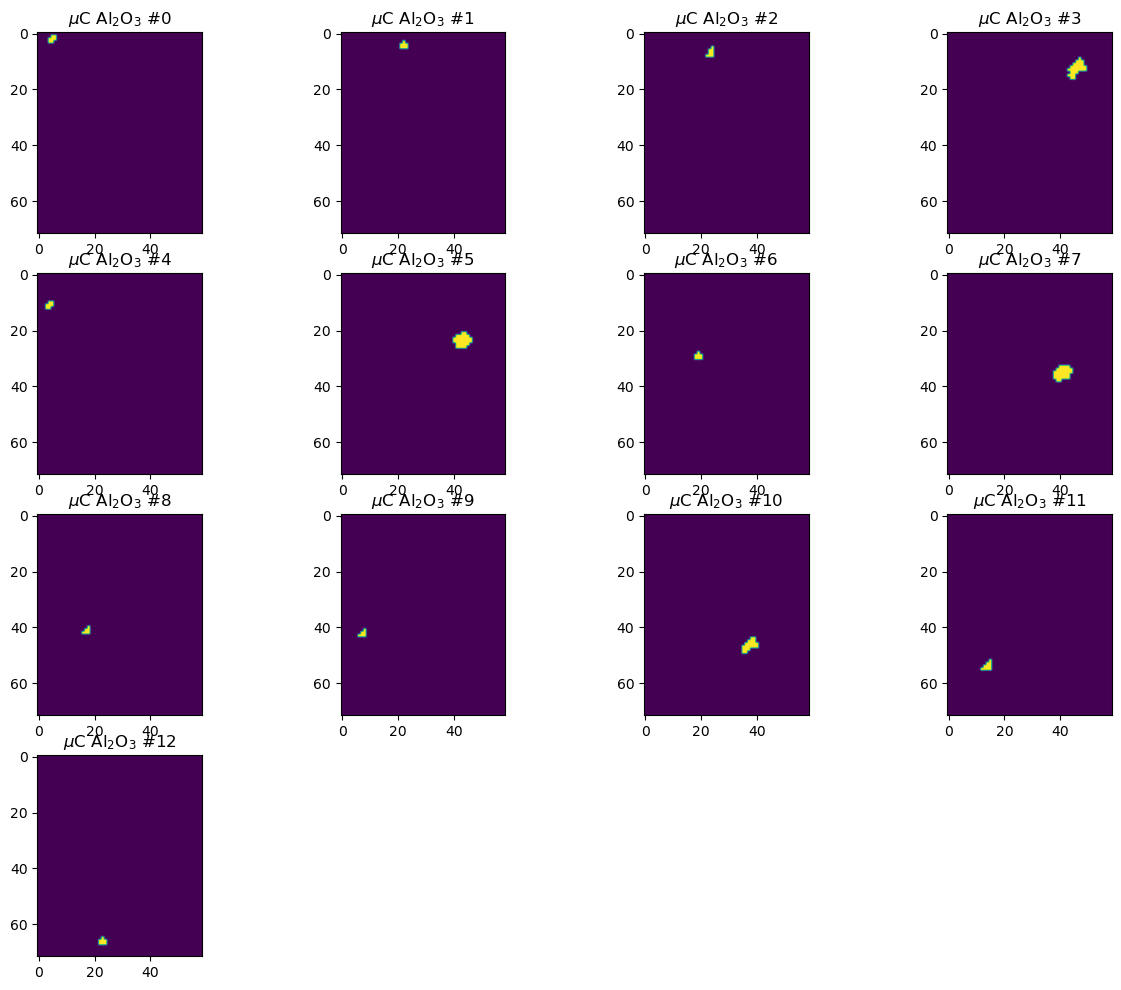

In [24]:
microsAlp1masks = []

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i, contour in enumerate(newcontours):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    microAlp1 = micros(microsAlp1,contour)
    microsAlp1masks.append(microAlp1)
    ax.imshow(microAlp1)
    ax.set_title(r"$\mu$C Al$_2$O$_3$ #{}".format(i))

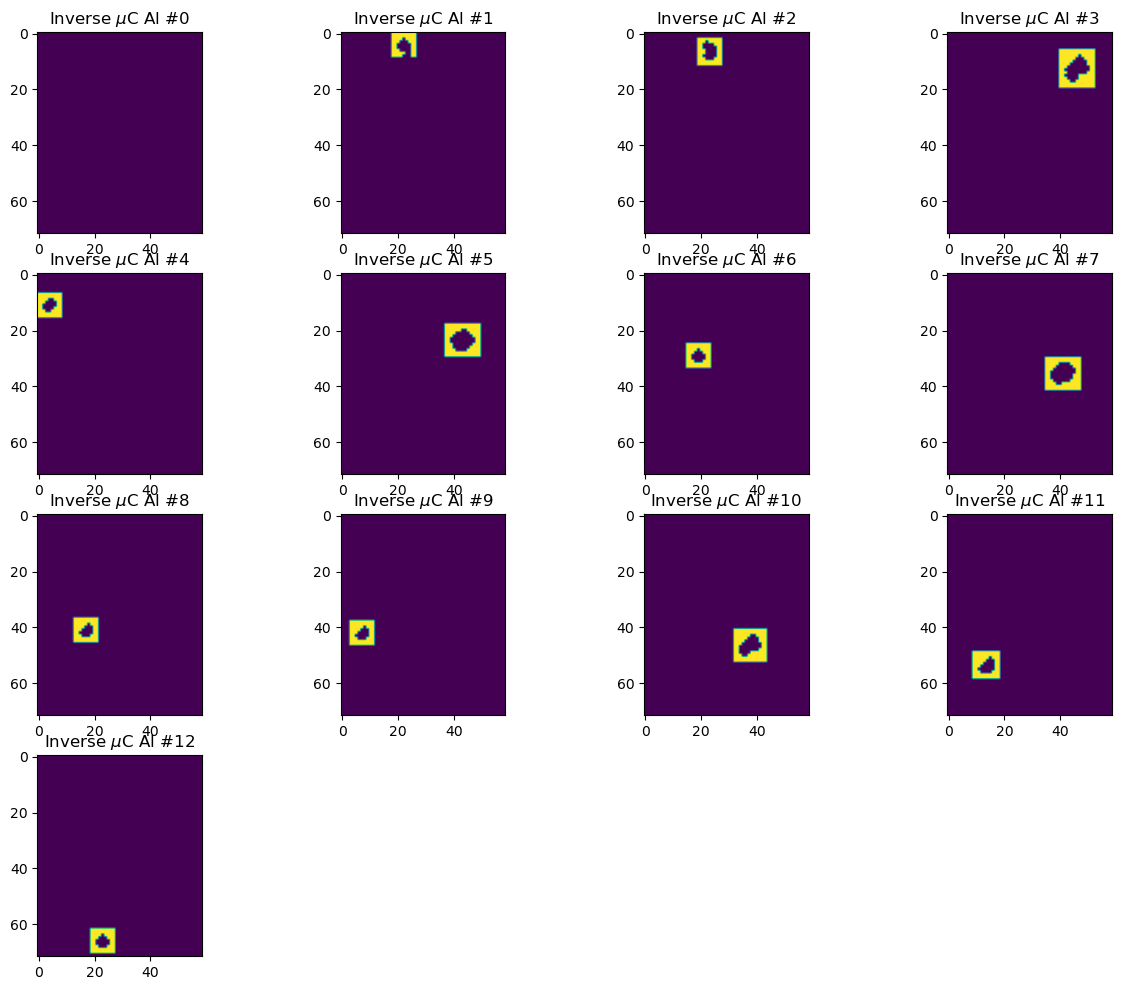

In [25]:
limits_microsAlp1 = []

for i, contour in enumerate(newcontours):
    mask_squaresAlp1 = np.zeros(microsAlp1.shape)
    left_border = int(np.amin(contour[:, 0]))
    right_border = int(np.amax(contour[:, 0]))
    upper_border = int(np.amin(contour[:, 1]))
    lower_border = int(np.amax(contour[:, 1]))
    mask_squaresAlp1[min(left_border,right_border)-padding_bkg:max(left_border,right_border)+padding_bkg+1, min(lower_border,upper_border)-padding_bkg:max(lower_border,upper_border)+padding_bkg+1] = 1
    limits_microsAlp1.append(mask_squaresAlp1)

masksinvAlp1 = 1 - ndimage.binary_dilation(np.array(microsAlp1masks), iterations=1)*np.array(limits_microsAlp1)


microsAlp1masksbkg = masksinvAlp1*np.array(limits_microsAlp1)


plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i, mask in enumerate(microsAlp1masksbkg):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(mask)
    ax.set_title(r"Inverse $\mu$C Al #{}".format(i))

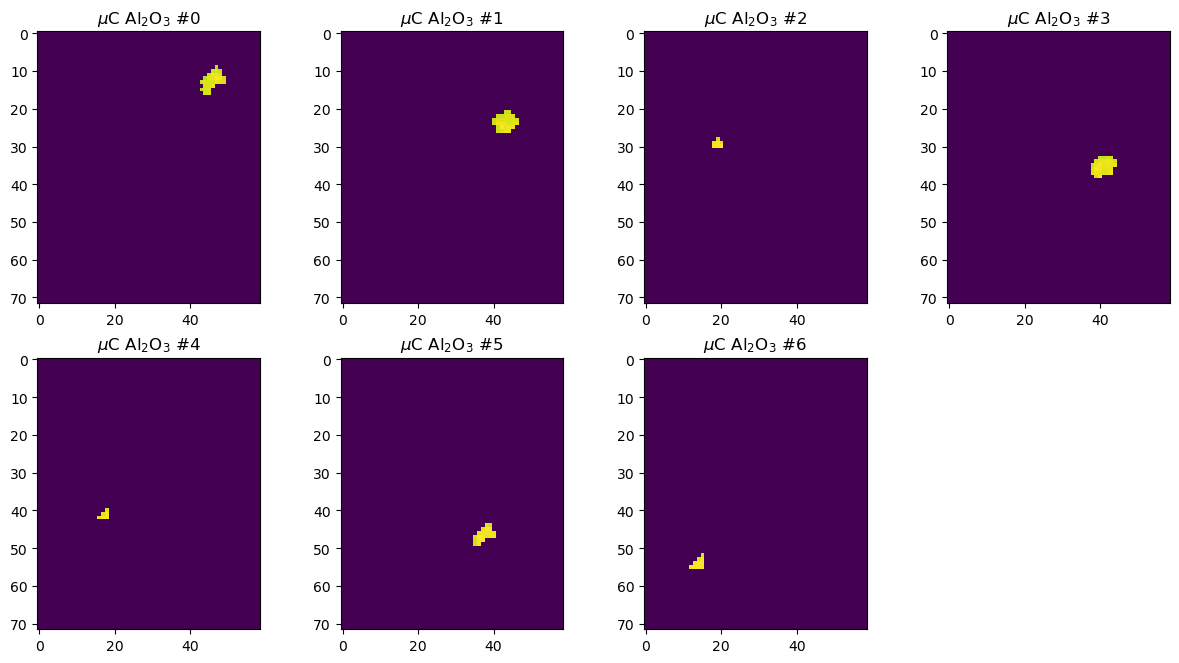

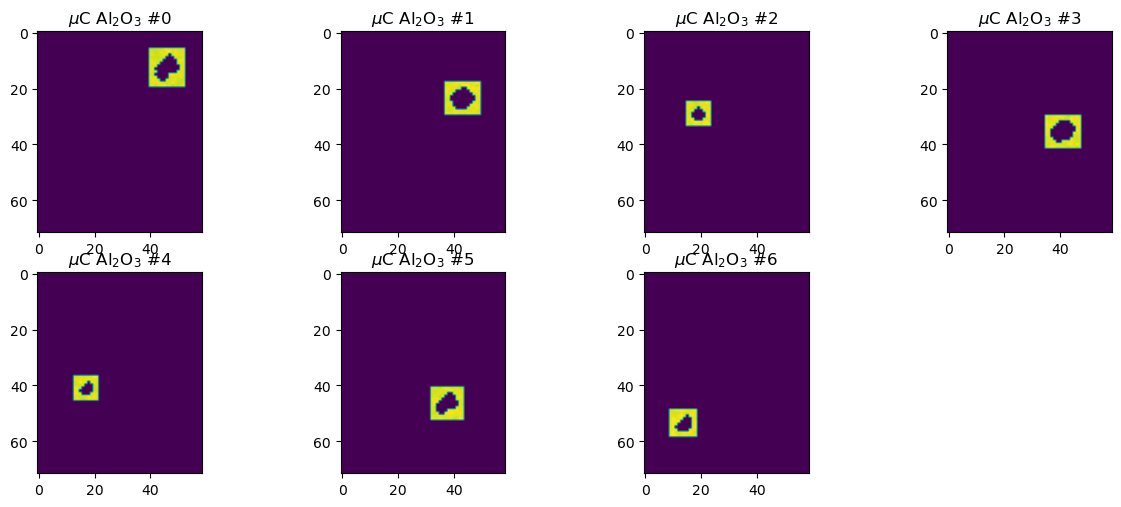

In [26]:
indicesAlp1micros = np.array([3,5,6,7,8,10,11]) # Indices de imagenes donde estan de verdad las micros

microsAlp1ind = [ microsAlp1*microsAlp1masks[i] for i in indicesAlp1micros ] # Creamos una lista donde cada i-esimo elemento es la imagen mltiplicada 
#por la mascara de una sola microcalcificacion

plt.figure(figsize=(15, 12))
n_rows_plot = 3
n_columns_plot = 4
for i in range(len(indicesAlp1micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsAlp1ind[i])
    ax.set_title(r"$\mu$C Al$_2$O$_3$ #{}".format(i))

microsAlp1indbkg = [ microsAlp1*microsAlp1masksbkg[i] for i in indicesAlp1micros ]

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i in range(len(indicesAlp1micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsAlp1indbkg[i])
    ax.set_title(r"$\mu$C Al$_2$O$_3$ #{}".format(i))

<ErrorbarContainer object of 3 artists>

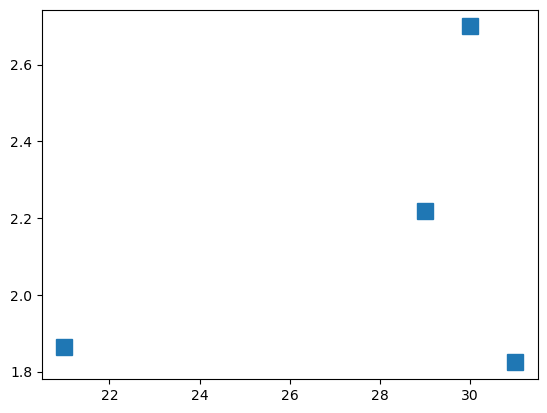

In [27]:
indicesAlp1micros600um = np.array([0,1,3,5])
indicesAlp1micros300um = np.array([2,4,6])

CNRs_Alp1_600um = [CNR(microsAlp1ind[index], microsAlp1indbkg[index],"normal")[0] for index in indicesAlp1micros600um]
errs_Alp1_600um = [CNR(microsAlp1ind[index], microsAlp1indbkg[index],"normal")[1] for index in indicesAlp1micros600um]
sizes_Alp1_600um = [np.count_nonzero(microsAlp1ind[index]) for index in indicesAlp1micros600um]

plt.errorbar(sizes_Alp1_600um, CNRs_Alp1_600um, yerr=errs_Alp1_600um, ls="none", marker='s', markersize=12)

<ErrorbarContainer object of 3 artists>

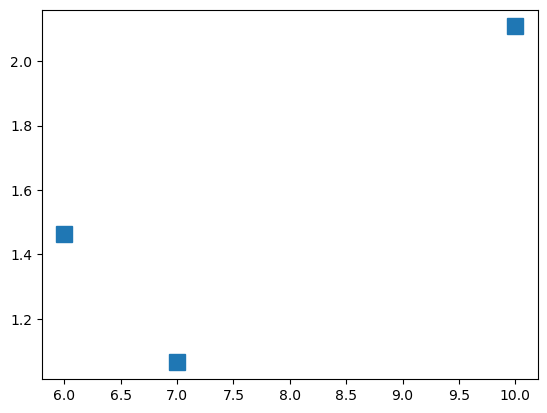

In [28]:
CNRs_Alp1_300um = [CNR(microsAlp1ind[index], microsAlp1indbkg[index],"normal")[0] for index in indicesAlp1micros300um]
errs_Alp1_300um = [CNR(microsAlp1ind[index], microsAlp1indbkg[index],"normal")[1] for index in indicesAlp1micros300um]
sizes_Alp1_300um = [np.count_nonzero(microsAlp1ind[index]) for index in indicesAlp1micros300um]

plt.errorbar(sizes_Alp1_300um, CNRs_Alp1_300um, yerr=errs_Alp1_300um, ls="none", marker='s', markersize=12)

# CNR de microcalcificaciones de fantoma 2

## Preparacion de datos

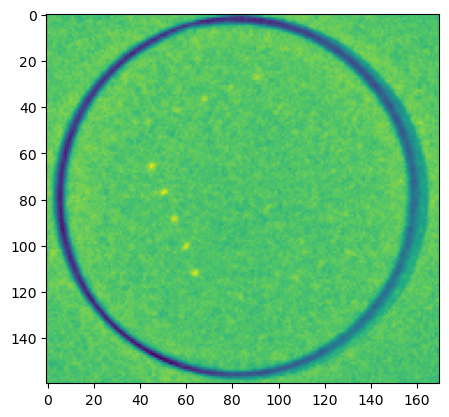

In [29]:
plt.imshow(phantom2)

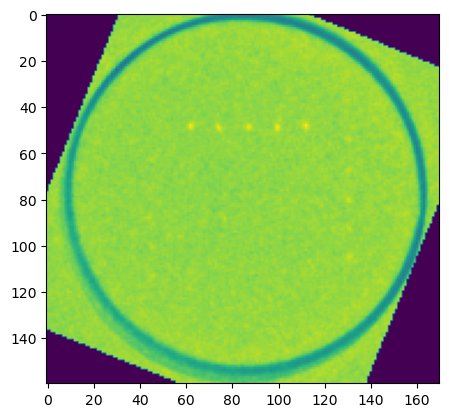

In [30]:
phantom2rot = ndimage.rotate(phantom2, -112, reshape=False)
plt.imshow(phantom2rot)

## Micros de HA

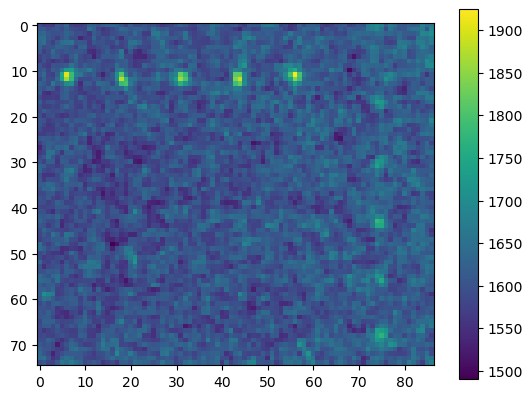

In [31]:
microsHAp2 = phantom2rot[37:112, 56:143]
plt.imshow(microsHAp2)
plt.colorbar()

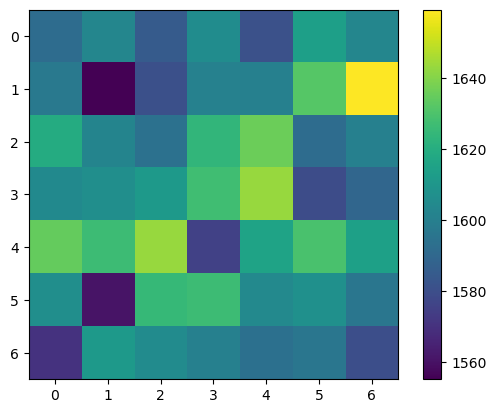

In [32]:
backgroundp2 = phantom2rot[60:60+bkg_size, 60:60+bkg_size]
plt.imshow(backgroundp2)
plt.colorbar()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5708\252374635.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newcontours = np.array(newcontours)


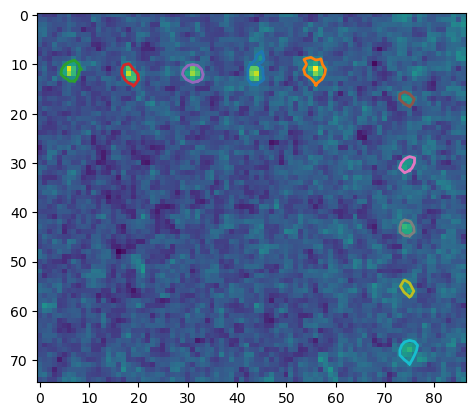

In [33]:
#th = threshold_otsu(microsHAp2)
contours = measure.find_contours(microsHAp2, 1670)
fig, ax = plt.subplots()
ax.imshow(microsHAp2)

len_contour_pix = 9

newcontours = []

for contour in contours:
    if(len(contour[:, 1]) > len_contour_pix):
        newcontours.append(contour)

newcontours = np.array(newcontours)

for contour in newcontours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

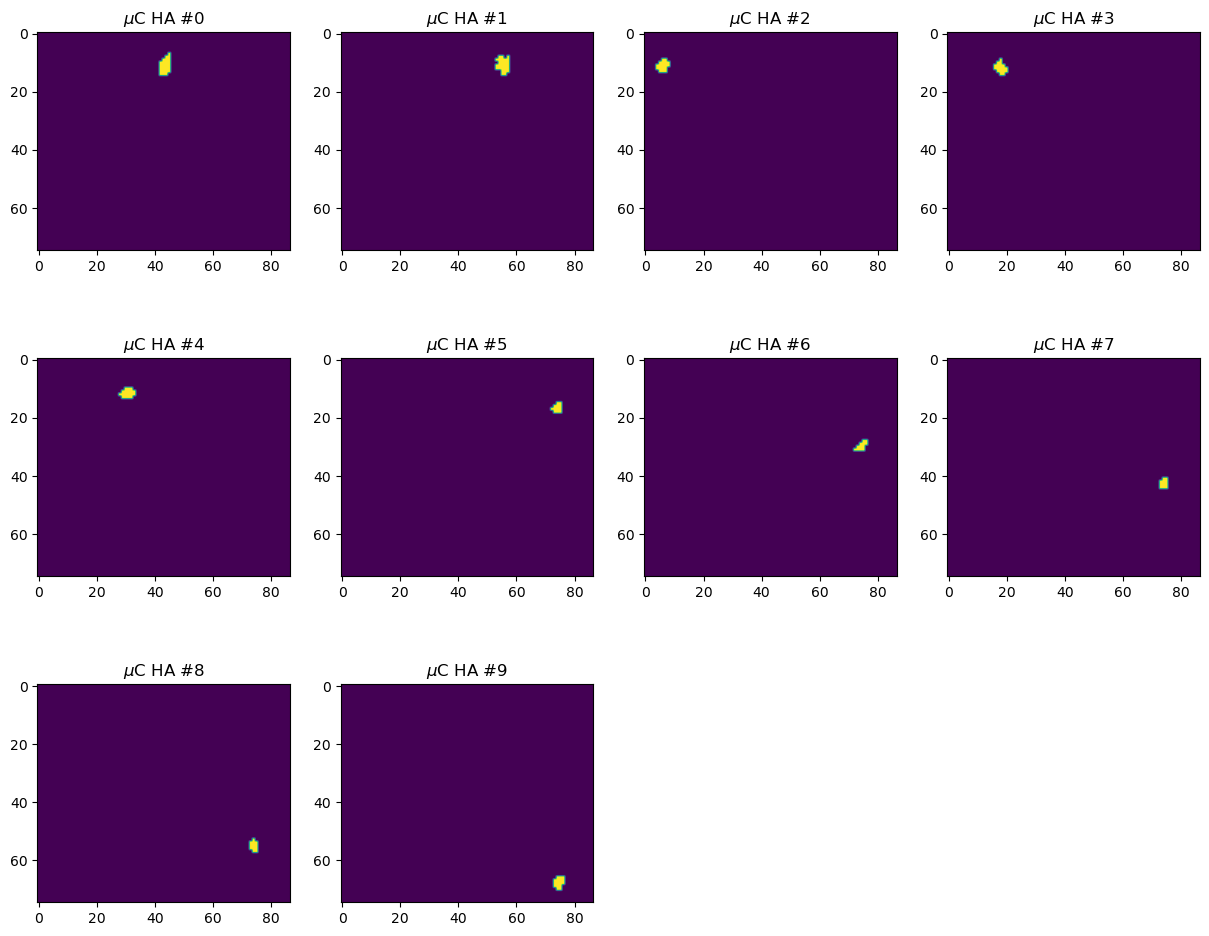

In [34]:
microsHAp2masks = []

plt.figure(figsize=(15, 12))
n_rows_plot = 3
n_columns_plot = 4
for i, contour in enumerate(newcontours):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    microHAp2 = micros(microsHAp2,contour)
    microsHAp2masks.append(microHAp2)
    ax.imshow(microHAp2)
    ax.set_title(r"$\mu$C HA #{}".format(i))

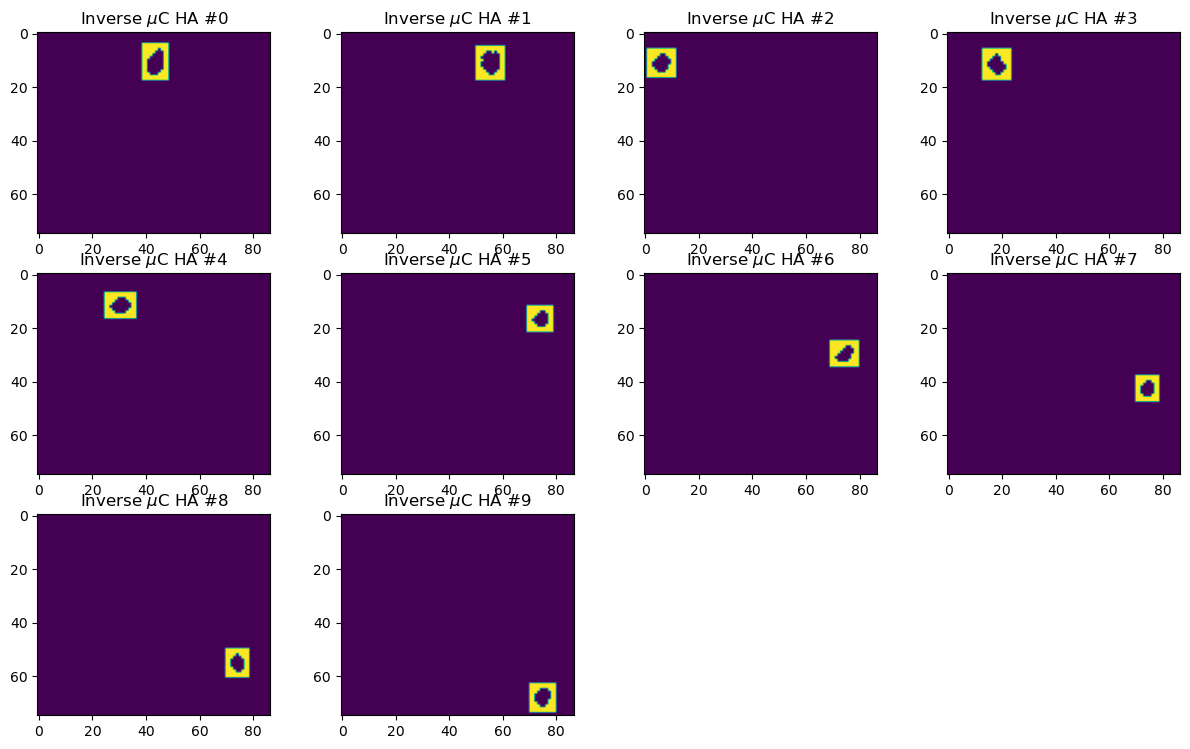

In [35]:
limits_microsHAp2 = []

for i, contour in enumerate(newcontours):
    mask_squaresHAp2 = np.zeros(microsHAp2.shape)
    left_border = int(np.amin(contour[:, 0]))
    right_border = int(np.amax(contour[:, 0]))
    upper_border = int(np.amin(contour[:, 1]))
    lower_border = int(np.amax(contour[:, 1]))
    mask_squaresHAp2[min(left_border,right_border)-padding_bkg:max(left_border,right_border)+padding_bkg+1, min(lower_border,upper_border)-padding_bkg:max(lower_border,upper_border)+padding_bkg+1] = 1
    limits_microsHAp2.append(mask_squaresHAp2)

masksinvHAp2 = 1 - ndimage.binary_dilation(np.array(microsHAp2masks), iterations=1)*np.array(limits_microsHAp2)

microsHAp2masksbkg = masksinvHAp2*np.array(limits_microsHAp2)


fig = plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i, mask in enumerate(microsHAp2masksbkg):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(mask)
    ax.set_title(r"Inverse $\mu$C HA #{}".format(i))

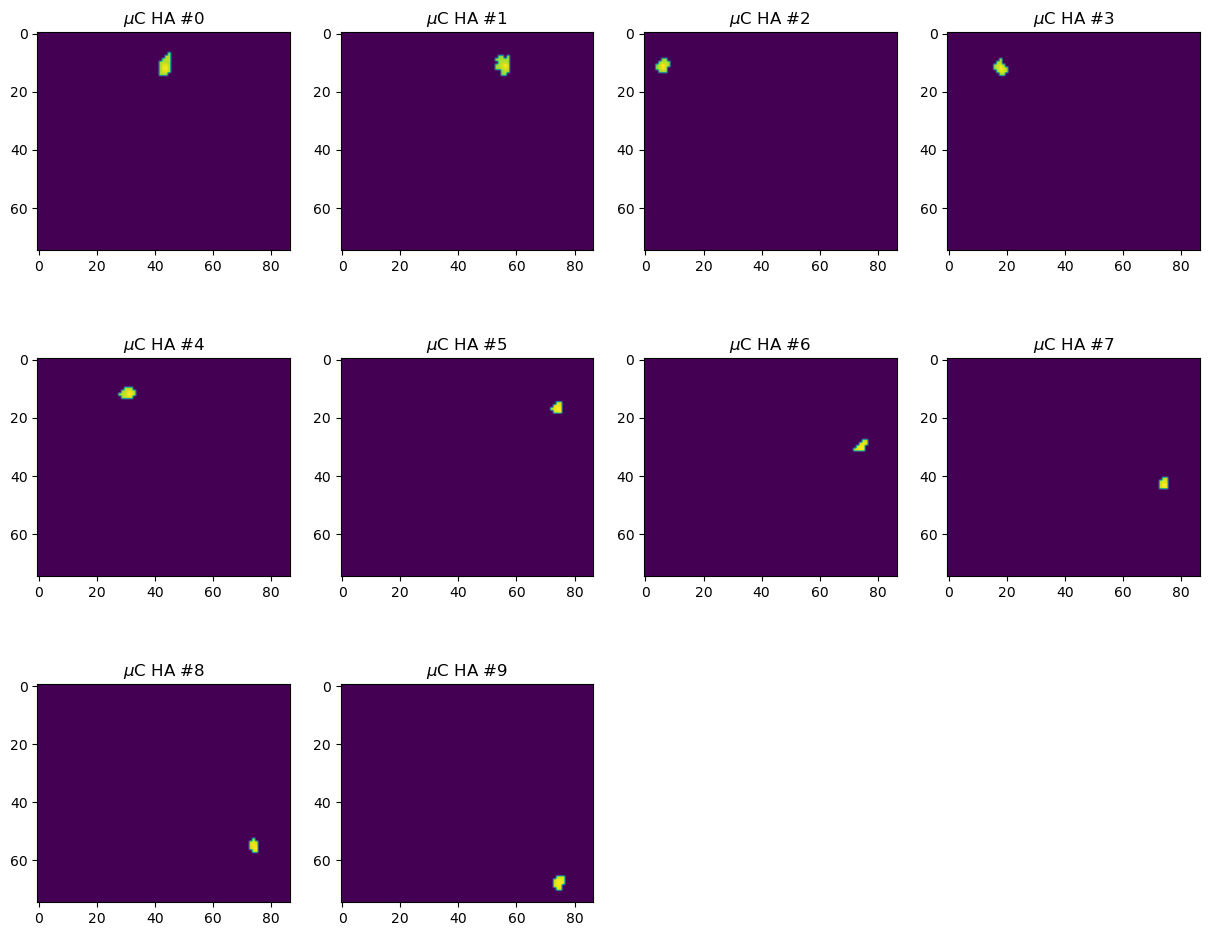

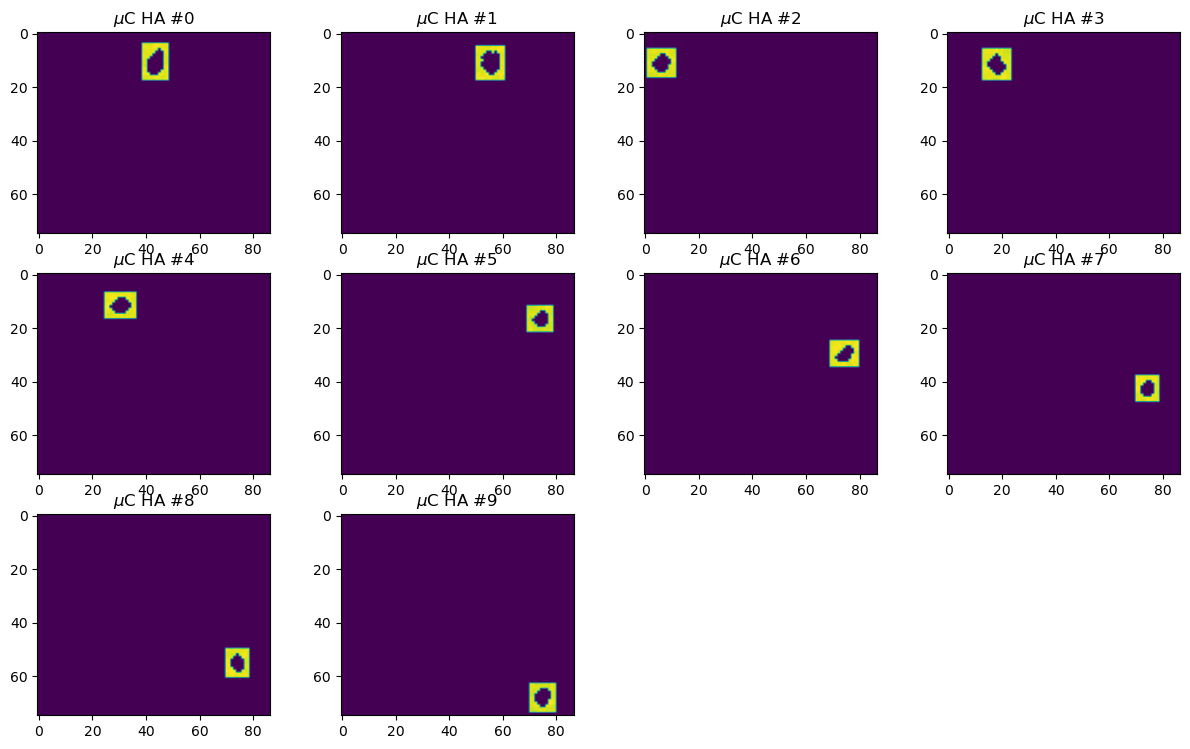

In [36]:
indicesHAp2micros = np.array([0,1,2,3,4,5,6,7,8,9]) # Indices de imagenes donde estan de verdad las micros

microsHAp2ind = [ microsHAp2*microsHAp2masks[i] for i in indicesHAp2micros ] # Creamos una lista donde cada i-esimo elemento es la imagen mltiplicada 
#por la mascara de una sola microcalcificacion

plt.figure(figsize=(15, 12))
n_rows_plot = 3
n_columns_plot = 4
for i in range(len(indicesHAp2micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsHAp2ind[i])
    ax.set_title(r"$\mu$C HA #{}".format(i))

microsHAp2indbkg = [ microsHAp2*microsHAp2masksbkg[i] for i in indicesHAp2micros ]

plt.figure(figsize=(15, 12))
n_rows_plot = 4
n_columns_plot = 4
for i in range(len(indicesHAp2micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsHAp2indbkg[i])
    ax.set_title(r"$\mu$C HA #{}".format(i))

<ErrorbarContainer object of 3 artists>

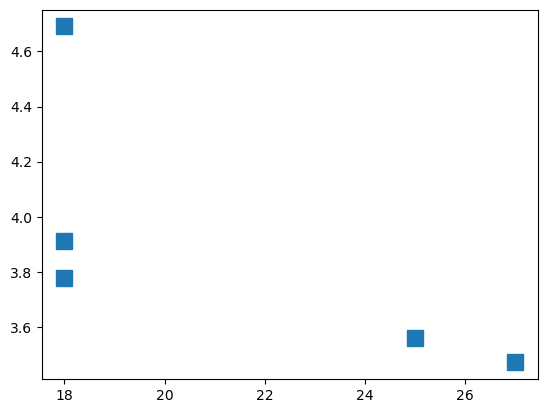

In [37]:
indicesHAp2micros500um = np.array([0,1,2,3,4])
indicesHAp2micros200um = np.array([5,6,7,8,9])

CNRs_HAp2_500um = [CNR(microsHAp2ind[index], microsHAp2indbkg[index],"normal")[0] for index in indicesHAp2micros500um]
errs_HAp2_500um = [CNR(microsHAp2ind[index], microsHAp2indbkg[index],"normal")[1] for index in indicesHAp2micros500um]
sizes_HAp2_500um = [np.count_nonzero(microsHAp2ind[index]) for index in indicesHAp2micros500um]

plt.errorbar(sizes_HAp2_500um, CNRs_HAp2_500um, yerr=errs_HAp2_500um, ls="none", marker='s', markersize=12)

<ErrorbarContainer object of 3 artists>

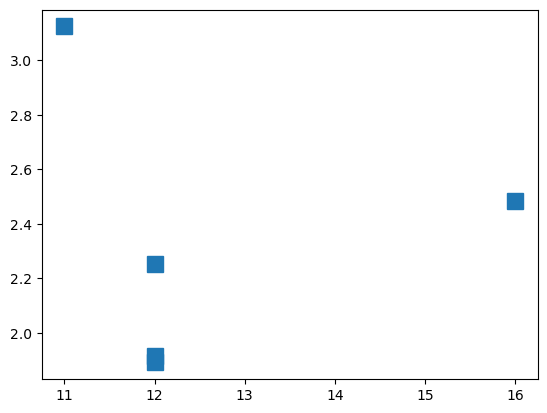

In [38]:
CNRs_HAp2_200um = [CNR(microsHAp2ind[index], microsHAp2indbkg[index],"normal")[0] for index in indicesHAp2micros200um]
errs_HAp2_200um = [CNR(microsHAp2ind[index], microsHAp2indbkg[index],"normal")[1] for index in indicesHAp2micros200um]
sizes_HAp2_200um = [np.count_nonzero(microsHAp2ind[index]) for index in indicesHAp2micros200um]

plt.errorbar(sizes_HAp2_200um, CNRs_HAp2_200um, yerr=errs_HAp2_200um, ls="none", marker='s', markersize=12)

## Micros de Al2O3

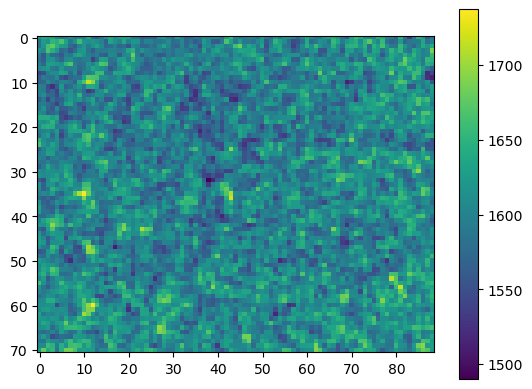

In [39]:
microsAlp2 = phantom2rot[53:124, 34:123]
plt.imshow(microsAlp2)
plt.colorbar()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5708\1957720842.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newcontours = np.array(newcontours)


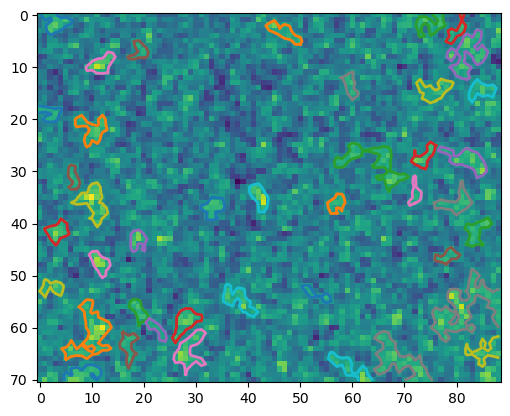

In [40]:
#th = threshold_otsu(microsAlp2)
contours = measure.find_contours(microsAlp2, 1625)
fig, ax = plt.subplots()
ax.imshow(microsAlp2)

len_contour_pix = 16

newcontours = []

for contour in contours:
    if(len(contour[:, 1]) > len_contour_pix):
        newcontours.append(contour)

newcontours = np.array(newcontours)

for contour in newcontours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

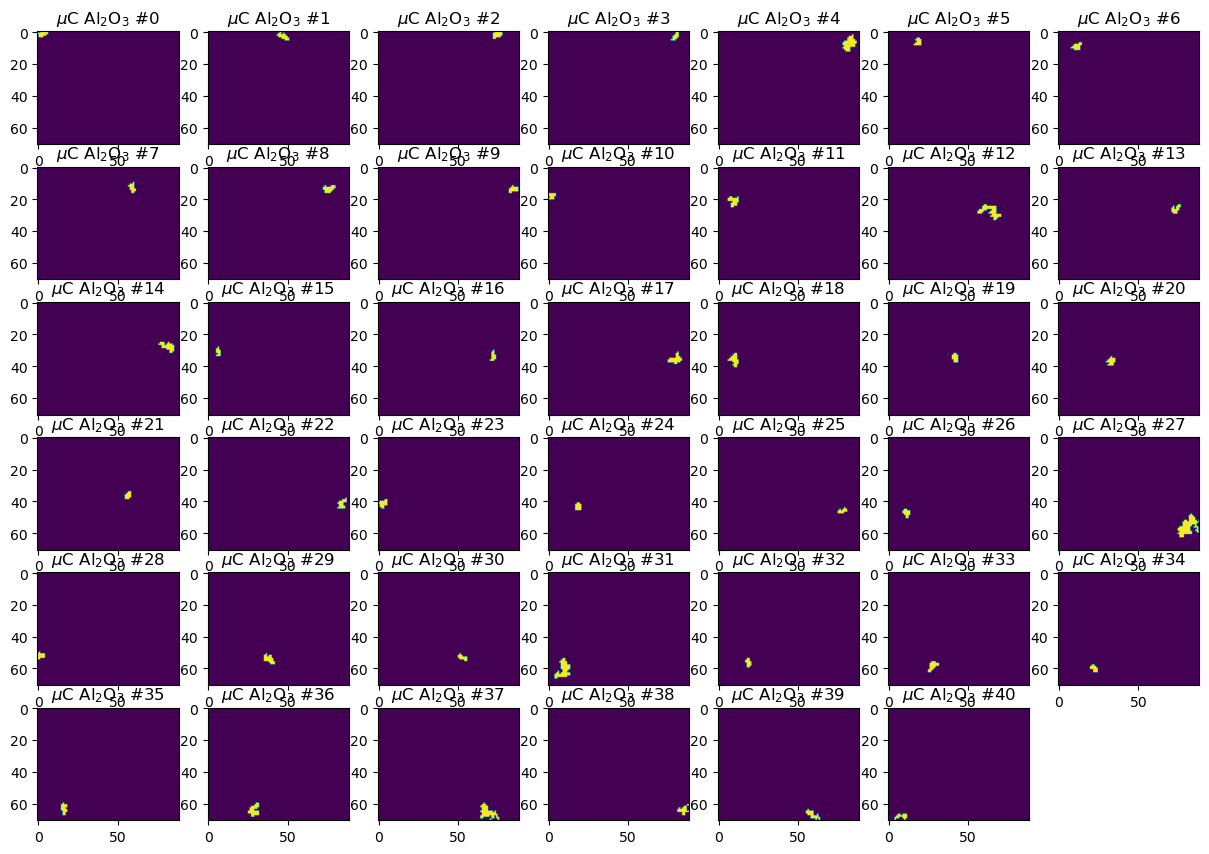

In [41]:
microsAlp2masks = []

plt.figure(figsize=(15, 12))
n_rows_plot = 7
n_columns_plot = 7
for i, contour in enumerate(newcontours):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    microAlp2 = micros(microsAlp2,contour)
    microsAlp2masks.append(microAlp2)
    ax.imshow(microAlp2)
    ax.set_title(r"$\mu$C Al$_2$O$_3$ #{}".format(i))

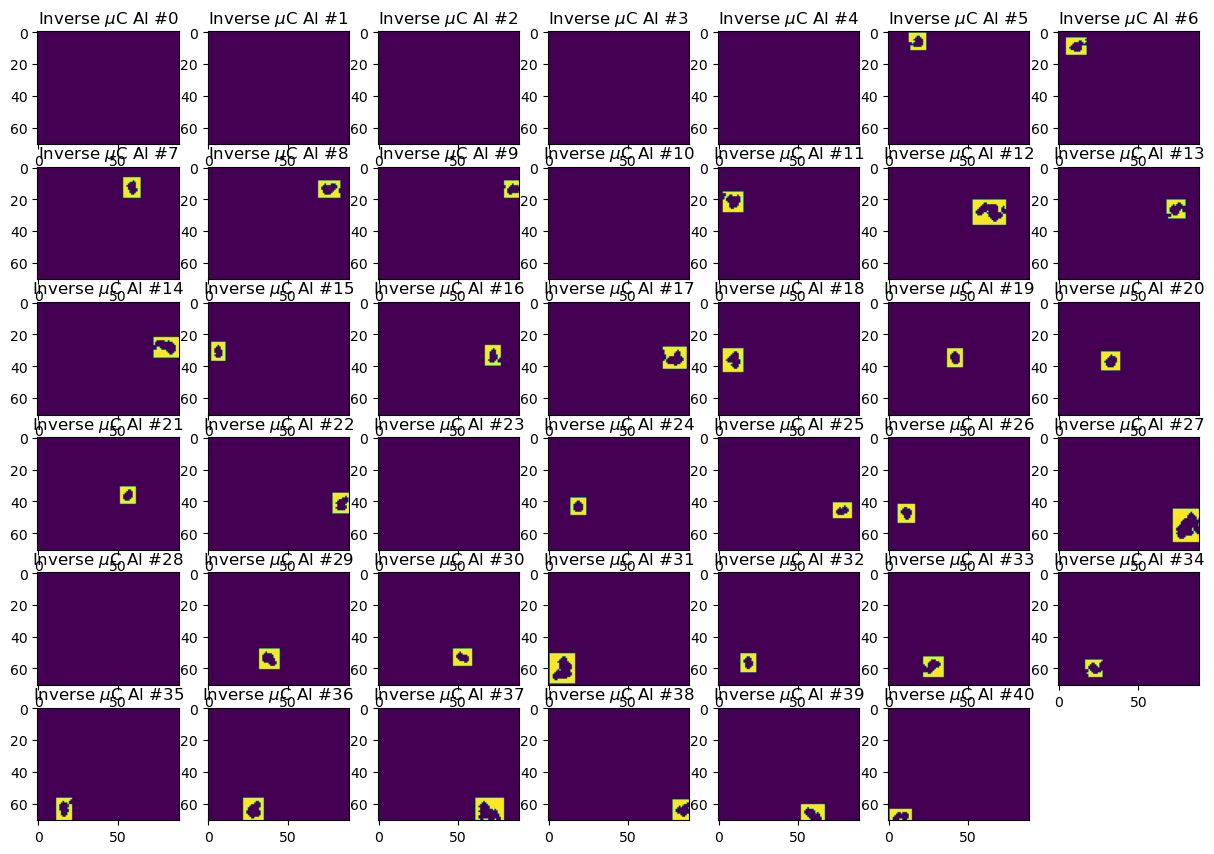

In [42]:
limits_microsAlp2 = []

for i, contour in enumerate(newcontours):
    mask_squaresAlp2 = np.zeros(microsAlp2.shape)
    left_border = int(np.amin(contour[:, 0]))
    right_border = int(np.amax(contour[:, 0]))
    upper_border = int(np.amin(contour[:, 1]))
    lower_border = int(np.amax(contour[:, 1]))
    mask_squaresAlp2[min(left_border,right_border)-padding_bkg:max(left_border,right_border)+padding_bkg+1, min(lower_border,upper_border)-padding_bkg:max(lower_border,upper_border)+padding_bkg+1] = 1
    limits_microsAlp2.append(mask_squaresAlp2)


masksinvAlp2 = 1 - ndimage.binary_dilation(np.array(microsAlp2masks), iterations=1)*np.array(limits_microsAlp2)
microsAlp2masksbkg = masksinvAlp2*np.array(limits_microsAlp2)


plt.figure(figsize=(15, 12))
n_rows_plot = 7
n_columns_plot = 7
for i, mask in enumerate(microsAlp2masksbkg):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(mask)
    ax.set_title(r"Inverse $\mu$C Al #{}".format(i))

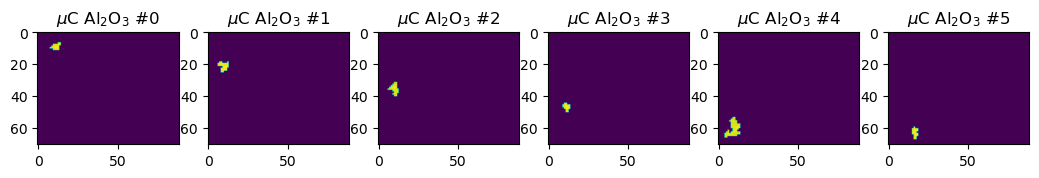

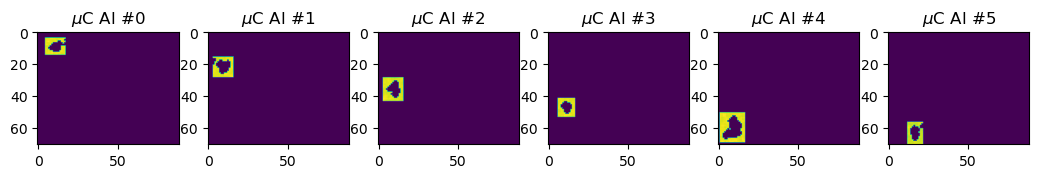

In [43]:
indicesAlp2micros = np.array([6,11,18,26,31,35]) # Indices de imagenes donde estan de verdad las micros

microsAlp2ind = [ microsAlp2*microsAlp2masks[i] for i in indicesAlp2micros ] # Creamos una lista donde cada i-esimo elemento es la imagen mltiplicada 
#por la mascara de una sola microcalcificacion

plt.figure(figsize=(15, 12))
n_rows_plot = 7
n_columns_plot = 7
for i in range(len(indicesAlp2micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsAlp2ind[i])
    ax.set_title(r"$\mu$C Al$_2$O$_3$ #{}".format(i))

microsAlp2indbkg = [ microsAlp2*microsAlp2masksbkg[i] for i in indicesAlp2micros ]

plt.figure(figsize=(15, 12))
n_rows_plot = 7
n_columns_plot = 7
for i in range(len(indicesAlp2micros)):
    ax = plt.subplot(n_rows_plot, n_columns_plot, i + 1)
    ax.imshow(microsAlp2indbkg[i])
    ax.set_title(r"$\mu$C Al #{}".format(i))

<ErrorbarContainer object of 3 artists>

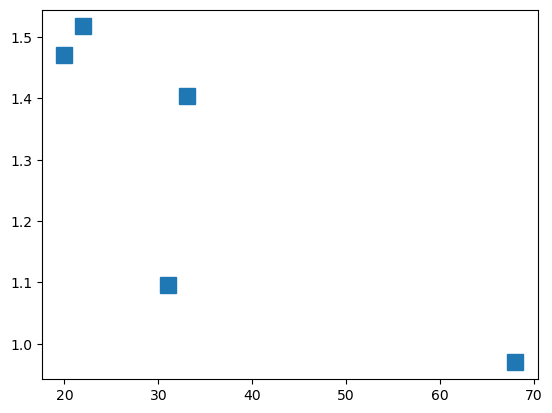

In [44]:
indicesAlp2micros500um = np.array([0,1,2,3,4])
indicesAlp2micros200um = np.array([5])

CNRs_Alp2_500um = [CNR(microsAlp2ind[index], microsAlp2indbkg[index],"normal")[0] for index in indicesAlp2micros500um]
errs_Alp2_500um = [CNR(microsAlp2ind[index], microsAlp2indbkg[index],"normal")[1] for index in indicesAlp2micros500um]
sizes_Alp2_500um = [np.count_nonzero(microsAlp2ind[index]) for index in indicesAlp2micros500um]

plt.errorbar(sizes_Alp2_500um, CNRs_Alp2_500um, yerr=errs_Alp2_500um, ls="none", marker='s', markersize=12)

<ErrorbarContainer object of 3 artists>

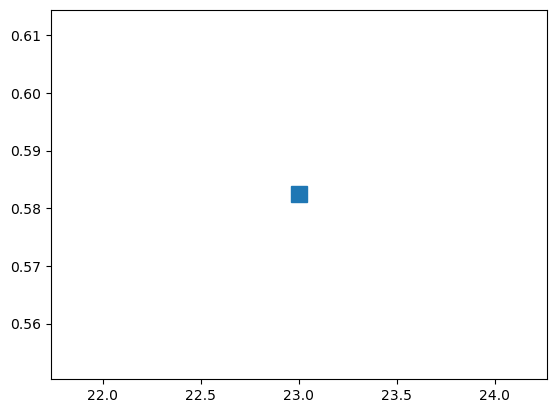

In [45]:
CNRs_Alp2_200um = [CNR(microsAlp2ind[index], microsAlp2indbkg[index],"normal")[0] for index in indicesAlp2micros200um]
errs_Alp2_200um = [CNR(microsAlp2ind[index], microsAlp2indbkg[index],"normal")[1] for index in indicesAlp2micros200um]
sizes_Alp2_200um = [np.count_nonzero(microsAlp2ind[index]) for index in indicesAlp2micros200um]

plt.errorbar(sizes_Alp2_200um, CNRs_Alp2_200um, yerr=errs_Alp2_200um, ls="none", marker='s', markersize=12)

## Boxplot con los CNRs

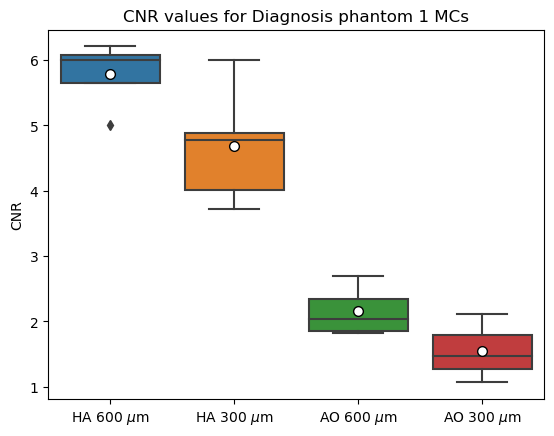

In [46]:
import seaborn as sns

all_arr = [CNRs_HAp1_600um, CNRs_HAp1_300um, CNRs_Alp1_600um, CNRs_Alp1_300um]

fig = plt.figure()
phantom1_CNR_boxplot = sns.boxplot(data=all_arr, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
phantom1_CNR_boxplot.set_title(r'CNR values for Diagnosis phantom 1 MCs')
phantom1_CNR_boxplot.set_ylabel(r'CNR')
phantom1_CNR_boxplot.set_xticks(range(len(all_arr)))
phantom1_CNR_boxplot.set_xticklabels([ r'HA 600 $\mu$m',r'HA 300 $\mu$m',r'AO 600 $\mu$m',r'AO 300 $\mu$m'])
fig.savefig("CNR_phantom1.svg")

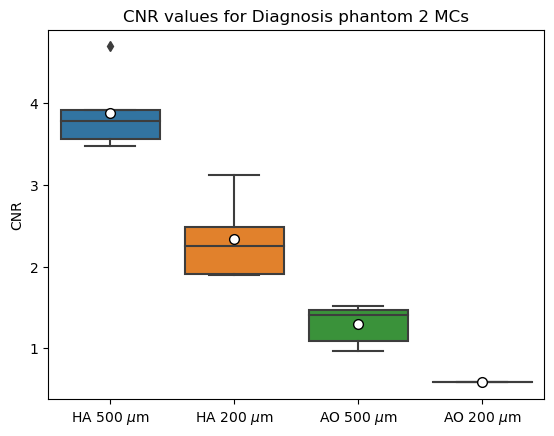

In [47]:
all_arr2 = [CNRs_HAp2_500um, CNRs_HAp2_200um, CNRs_Alp2_500um, CNRs_Alp2_200um]

fig=plt.figure()
phantom2_CNR_boxplot = sns.boxplot(data=all_arr2, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
phantom2_CNR_boxplot.set_title(r'CNR values for Diagnosis phantom 2 MCs')
phantom2_CNR_boxplot.set_ylabel(r'CNR')
phantom2_CNR_boxplot.set_xticks(range(len(all_arr2)))
phantom2_CNR_boxplot.set_xticklabels([ r'HA 500 $\mu$m',r'HA 200 $\mu$m',r'AO 500 $\mu$m',r'AO 200 $\mu$m'])
fig.savefig("CNR_phantom2.svg")

# Matriz de atenuación

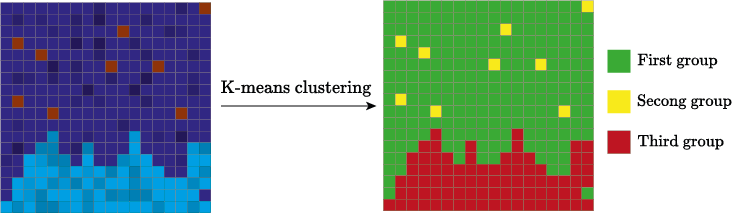

In [48]:
Image(filename='kmeans_escalera.png')

In [49]:
steps = [step1,step2,step3,step4,step5,step6,step7,step8,step9]

for i,step in enumerate(steps):
    np.savetxt("step{}.txt".format(i+1), step)

(array([  2.,   1.,  14.,  54., 100., 123., 309., 237., 221., 290., 133.,
         55.,  44.,   9.,   8.]),
 array([405.        , 407.33333333, 409.66666667, 412.        ,
        414.33333333, 416.66666667, 419.        , 421.33333333,
        423.66666667, 426.        , 428.33333333, 430.66666667,
        433.        , 435.33333333, 437.66666667, 440.        ]),
 <BarContainer object of 15 artists>)

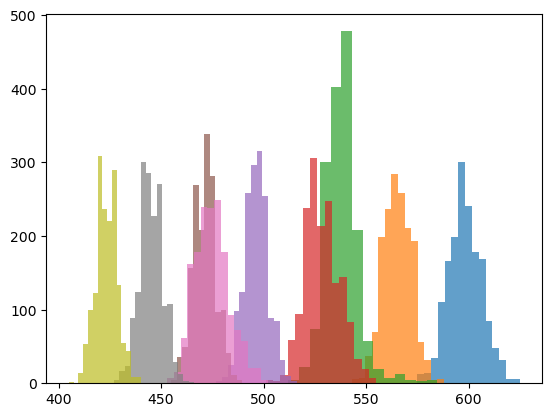

In [50]:
plt.hist(np.ravel(step1), bins=15, alpha=0.7)
plt.hist(np.ravel(step2), bins=15, alpha=0.7)
plt.hist(np.ravel(step3), bins=15, alpha=0.7)
plt.hist(np.ravel(step4), bins=15, alpha=0.7)
plt.hist(np.ravel(step5), bins=15, alpha=0.7)
plt.hist(np.ravel(step6), bins=15, alpha=0.7)
plt.hist(np.ravel(step7), bins=15, alpha=0.7)
plt.hist(np.ravel(step8), bins=15, alpha=0.7)
plt.hist(np.ravel(step9), bins=15, alpha=0.7)

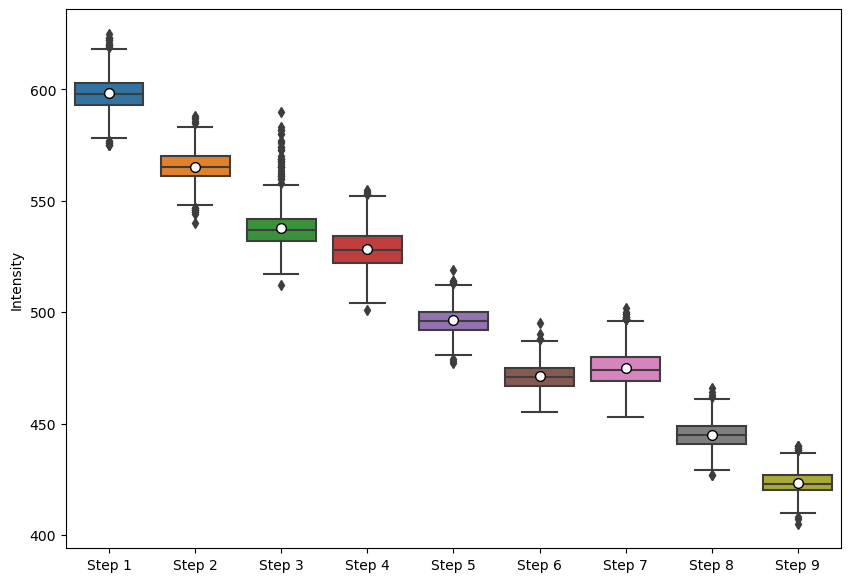

In [51]:
all_arrmatrix = [step1,step2,step3,step4,step5,step6,step7,step8,step9]

fig = plt.figure(figsize=(10,7))
matrix_boxplot = sns.boxplot(data=all_arrmatrix, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
#matrix_boxplot.set_title(r'Attenuation matrix intensities')
matrix_boxplot.set_ylabel(r'Intensity')
matrix_boxplot.set_xticks(range(len(all_arrmatrix)))
matrix_boxplot.set_xticklabels([ r'Step 1',r'Step 2',r'Step 3',r'Step 4',r'Step 5',r'Step 6',r'Step 7',r'Step 8',r'Step 9',])
fig.savefig("boxesmatrix.svg")


In [52]:
new_steps_im = []

for i in range(9):
    new_steps_im.append(np.genfromtxt("new_step{}.txt".format(i)))

new_steps_ravel = []

for step in new_steps_im:
    new_steps_ravel.append( np.ravel(step)[np.where(np.ravel(step) !=0)] )

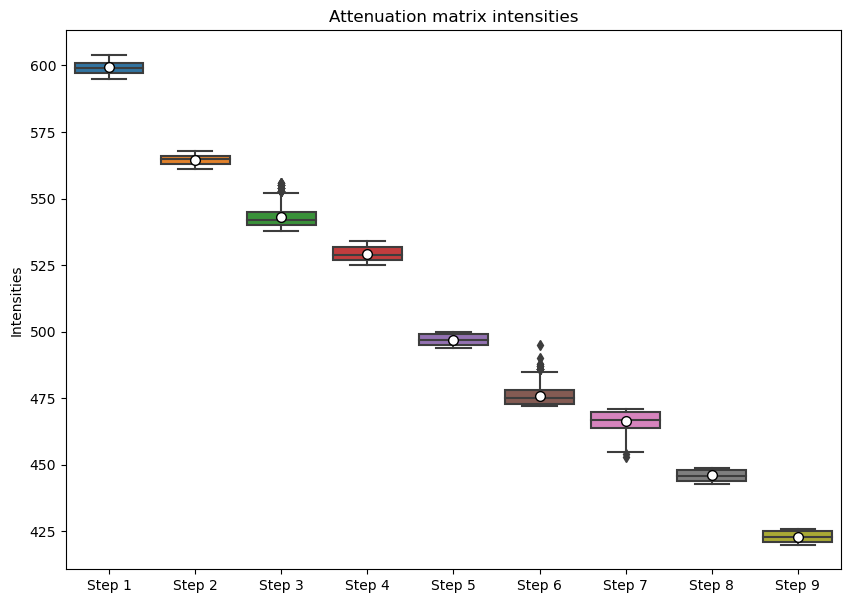

In [53]:
fig=plt.figure(figsize=(10,7))
matrix_boxplot = sns.boxplot(data=new_steps_ravel, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
matrix_boxplot.set_title(r'Attenuation matrix intensities')
matrix_boxplot.set_ylabel(r'Intensities')
matrix_boxplot.set_xticks(range(len(new_steps_ravel)))
matrix_boxplot.set_xticklabels([ r'Step 1',r'Step 2',r'Step 3',r'Step 4',r'Step 5',r'Step 6',r'Step 7',r'Step 8',r'Step 9'])
plt.savefig("boxesmatrix_corrected.svg")

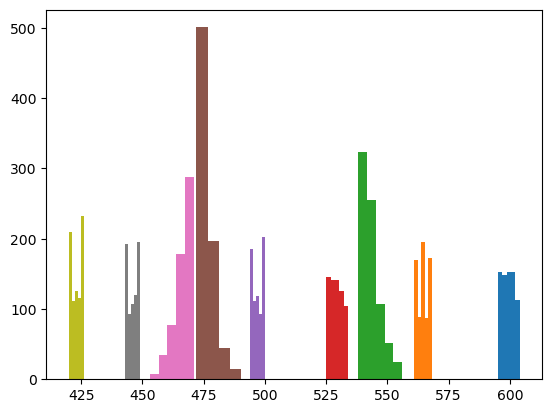

In [54]:
for step in new_steps_im:
    plt.hist(np.ravel(step)[np.where(np.ravel(step) !=0)], bins=5) 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5708\1433390296.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_steps_ravel_norm = (np.array(new_steps_ravel) - means_newmatrix[8])/std_newmatrix[8]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


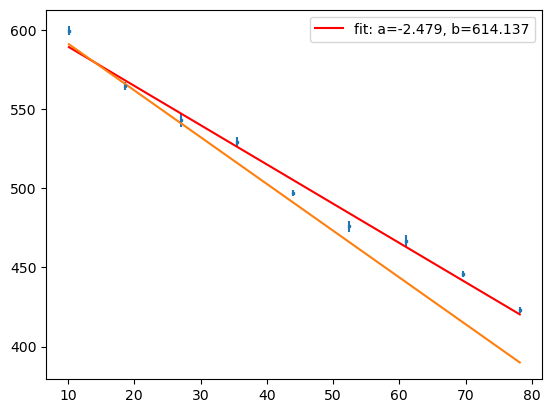

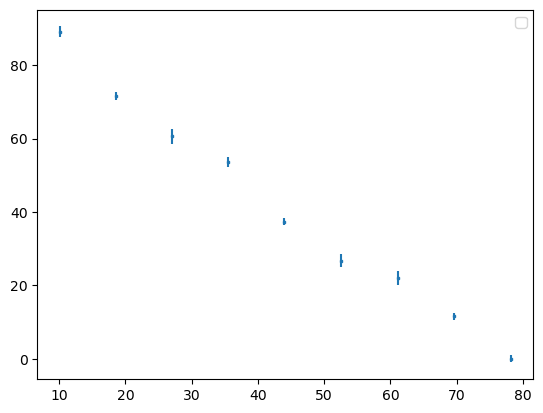

In [55]:
adipose_percentages = np.genfromtxt("adipose_percentages.txt")
glandular_percentages = 100*(1-adipose_percentages)
means_newmatrix = np.array([np.mean(step) for step in new_steps_ravel])
std_newmatrix = np.array([np.std(step) for step in new_steps_ravel])
new_steps_ravel_norm = (np.array(new_steps_ravel) - means_newmatrix[8])/std_newmatrix[8]

means = np.array([np.mean(step) for step in new_steps_ravel_norm])
std = np.array([np.std(step) for step in new_steps_ravel_norm])

np.savetxt("means_intensity.txt", means)
np.savetxt("errors_intensity.txt", std)


popt, pcov = curve_fit(line, glandular_percentages, means_newmatrix)

plt.figure()
plt.errorbar(glandular_percentages, means_newmatrix, yerr=std_newmatrix, ls="none", marker='s', markersize=2)
plt.plot(glandular_percentages, line(glandular_percentages, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(glandular_percentages, -2.952*glandular_percentages + 620.732)
plt.legend()

plt.figure()
plt.errorbar(glandular_percentages, means, yerr=std, ls="none", marker='s', markersize=2)
#plt.plot(glandular_percentages, line(glandular_percentages, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend()



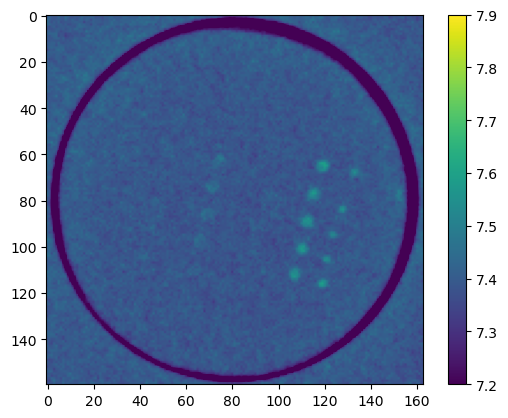

In [56]:
plt.imshow(np.log(phantom1), vmin= 7.2,vmax=7.9)
plt.colorbar()
plt.savefig("fantoma1.svg")

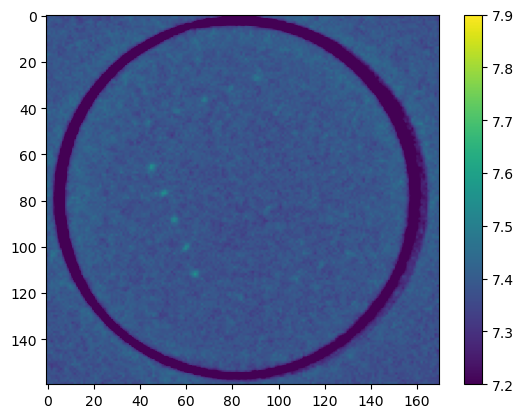

In [57]:
plt.imshow(np.log(phantom2), vmin= 7.2,vmax=7.9)
plt.colorbar()
plt.savefig("fantoma2.svg")